In [1]:
import sys, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
subm = pd.read_csv("SampleSubmission.csv")
label_cols = ['Alcohol', 'Depression', 'Drugs', 'Suicide']

In [3]:
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [4]:
le = LabelEncoder()
train['label_encoded'] = 1
train.head(50)

,ID,text,label,label_encoded
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,1
1,9JDAGUV3,Why do I get hallucinations?,Drugs,1
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,1
3,6UY7DX6Q,Why is life important?,Suicide,1
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,1
5,V6VSDJ5I,What are the effects of depression to ones health,Depression,1
6,9736J4UE,Why is everything so hard to deal with in this...,Depression,1
7,AY8L479Y,I feel emotionally overwhelmed,Depression,1
8,OSFJV5EC,How to manage taking alcohol?,Alcohol,1
9,U4SGUGGM,Is heaven open for us who smoke bhang?,Drugs,1


In [5]:
train = train.pivot_table('label_encoded', ['ID', 'text'], 'label')
train.reset_index( drop=False, inplace=True )
train.reindex(['ID', 'text', 'Alcohol', 'Depression', 'Drugs', 'Suicide'], axis=1)
del train.columns.name
train.replace(np.nan, 0, inplace=True)
train[label_cols] = train[label_cols].astype(int)
train

,ID,text,Alcohol,Depression,Drugs,Suicide
0,019YKKY0,"I feel bad about myself, I dont want to intera...",0,1,0,0
1,03TVUJ9J,"I feel empty,absent minded",0,1,0,0
2,09UQ1YVQ,I went bankrupt because of alcohol,1,0,0,0
3,0HK6V5IQ,I am bored,0,1,0,0
4,0KPI3LLQ,How to avoid bad company?,1,0,0,0
5,0LPO6TKU,What should i do to get out of depression?,0,1,0,0
6,0OSLJ1HL,Where can i get money to be drinking daily?,1,0,0,0
7,0QXYZFYQ,I feel like I am a nobody,0,1,0,0
8,0RFTD03Y,How to deal and overcome bad situation,0,0,0,1
9,0RLWLLGO,How can I stop this addiction,1,0,0,0


In [6]:
train.isnull().any()

ID            False
text          False
Alcohol       False
Depression    False
Drugs         False
Suicide       False
dtype: bool

In [7]:
list_classes = ['Alcohol', 'Depression', 'Drugs', 'Suicide']
y = train[list_classes]
list_sentences_train = train['text']
list_sentences_test = test['text']

In [8]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

#Sneak peek into list tokenized training
list_tokenized_train[:1]

[[1, 4, 59, 82, 48, 1, 153, 103, 2, 362, 18, 200]]

In [9]:
maxlen = 30
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

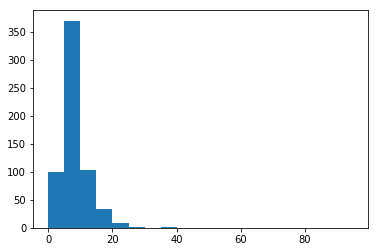

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords, bins = np.arange(0, 100, 5))
plt.show()

In [11]:
inp = Input(shape=(maxlen, ))

In [12]:
embed_size = 512
x = Embedding(max_features, embed_size)(inp)

In [13]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [14]:
x = GlobalMaxPool1D()(x)

In [15]:
x = Dropout(0.1)(x)

In [16]:
x = Dense(50, activation='relu')(x)

In [17]:
x = Dropout(0.1)(x)

In [18]:
x = Dense(4, activation='sigmoid')(x)

In [19]:
model = Model(input=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [20]:
batch_size = 32
epochs = 50
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.33)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 412 samples, validate on 204 samples
Epoch 1/50
412/412 [==============================] - 3s 7ms/step - loss: 0.6719 - accuracy: 0.6911 - val_loss: 0.6178 - val_accuracy: 0.7782
Epoch 2/50
412/412 [==============================] - 1s 3ms/step - loss: 0.5363 - accuracy: 0.7731 - val_loss: 0.4870 - val_accuracy: 0.7819
Epoch 3/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4796 - accuracy: 0.7840 - val_loss: 0.4749 - val_accuracy: 0.7819
Epoch 4/50
412/412 [==============================] - 1s 3ms/step - loss: 0.4729 - accuracy: 0.7882 - val_loss: 0.4743 - val_accuracy: 0.7819
Epoch 5/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4753 - accuracy: 0.7791 - val_loss: 0.4705 - val_accuracy: 0.7819
Epoch 6/50
412/412 [==============================] - 1s 3ms/step - loss: 0.4600 - accuracy: 0.7973 - val_loss: 0.4626 - val_accuracy: 0.7843
Epoch 7/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4479 - accuracy: 0.8149 - 

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 200)           4000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 30, 60)            62640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [22]:
predictions = model.predict(X_te)


In [23]:
label_cols = ['Alcohol', 'Depression', 'Drugs', 'Suicide']
submid = pd.DataFrame({'id': subm["ID"]})
submission = pd.concat([submid, pd.DataFrame(predictions, columns = label_cols)], axis=1)
submission.to_csv('Submission-Keras.csv', index=False)
submission

,id,Alcohol,Depression,Drugs,Suicide
0,02V56KMO,0.004441,0.280261,0.000112,0.432032
1,03BMGTOK,0.000003,0.999956,0.000089,0.000180
2,03LZVFM6,0.000015,0.999658,0.000017,0.001791
3,0EPULUM5,0.000004,0.999961,0.000037,0.000202
4,0GM4C5GD,0.233016,0.001684,0.472674,0.003798
5,0IYM8BYT,0.000064,0.995146,0.000412,0.012359
6,0JFJVD28,0.000010,0.998936,0.002065,0.000947
7,0OZGUFOF,0.000008,0.998643,0.000828,0.003468
8,0WP999ZX,0.995935,0.000064,0.006451,0.001038
9,0ZA45Y5F,0.247033,0.013774,0.000740,0.151390
